In [1]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training

In [2]:
# Display?
display_subset = False
how_many = 5
####################

n_features = 1000
n_targets = n_features

x = np.linspace(-10, 10, n_features)

n_samples_V = 100
n_samples_H_0 = 100

rng = np.random.default_rng(seed=99)
V_arr_train = np.random.uniform(1, 10, n_samples_V)
H_0_arr_train = np.random.uniform(1, 10, n_samples_H_0)

train_params = np.array(list(itertools.product(V_arr_train, H_0_arr_train)))
n_samples_train = train_params.shape[0]

x_train = np.zeros((n_samples_train, n_features))
y_train = np.zeros((n_samples_train, n_targets))

for i, params in enumerate(train_params):
    x_train[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])
    y_train[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])

    if (i+1) % int(n_samples_train/how_many) == 0 and display_subset:
        print(f'{i+1}/{n_samples_train}: V = {params[0]}, H_0 = {params[1]}')
        plt.figure()
        plt.plot(x, x_train[i, :], label='x_train')
        plt.plot(x, y_train[i, :], label='y_train')
        plt.legend()
        plt.show()


In [3]:
reg = first_model(low_dim_x=5, low_dim_y=1, low_dim_regressor=GP_regressor)
reg.fit(x_train, y_train, save=True)

<class 'models.GP_regressor'>
[[-4.64916595e+00  7.30500372e+00 -2.73765254e+00  1.72911224e+00
  -8.22922397e-01]
 [ 8.27705903e+00 -8.25882492e+00 -7.02230103e-01 -2.60459130e+00
  -6.88632682e-02]
 [-1.73035902e+01  8.70132575e+00  2.79707084e-01 -2.56944345e+00
   6.33291981e-01]
 ...
 [ 1.83921563e+01 -9.01202575e+00  7.39714340e-01 -2.97194922e+00
   3.69375994e-01]
 [-7.40888251e+00  1.22472473e+01  2.09950317e+00 -1.14747397e-02
  -1.34969438e+00]
 [-9.43089778e+00  1.22365631e+01  2.56036981e+00 -9.18565098e-01
  -8.94247382e-01]]
[[-0.45709562]
 [-0.38157695]
 [-0.83996113]
 ...
 [ 2.89676208]
 [ 2.63351625]
 [ 2.56750461]]


AttributeError: module 'gpjax' has no attribute 'models'

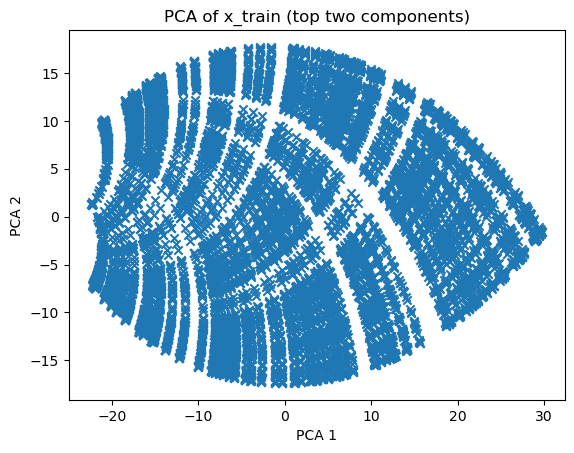

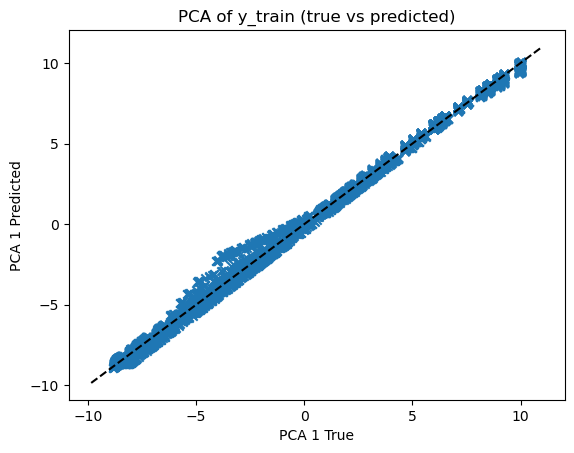

MSE: 0.05507668916137015
Correlation: 0.9990269990562345


In [16]:
# assess how well the low-dimensional regression is doing

plt.figure()
plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of x_train (top two components)')
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0], marker='x', alpha=1)
plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
plt.xlabel('PCA 1 True')
plt.ylabel('PCA 1 Predicted')
plt.title('PCA of y_train (true vs predicted)')
plt.show()

mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim, reg.Y_train_low_dim_pred)
print(f'MSE: {mse}')
r = np.corrcoef(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0])
print(f'Correlation: {r[0, 1]}')

# Testing

In [17]:
n_samples_V_test = 100
n_samples_H_0_test = 100

rng = np.random.default_rng(seed=98)
V_arr_test = np.linspace(0.01, 10, n_samples_V_test)
H_0_arr_test = np.linspace(0.01, 10, n_samples_H_0_test)

test_params = np.array(list(itertools.product(V_arr_test, H_0_arr_test)))
n_samples_test = test_params.shape[0]
test_params_arr = test_params.reshape((n_samples_V_test, n_samples_H_0_test, 2))

x_test = np.zeros((n_samples_test, n_features))
y_test = np.zeros((n_samples_test, n_targets))

for i, params in enumerate(test_params):
    x_test[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])
    y_test[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])

index 9905 was the worst result with an RMSE of 0.2127225930268671 for V=10.0 and H_0=0.5145454545454545


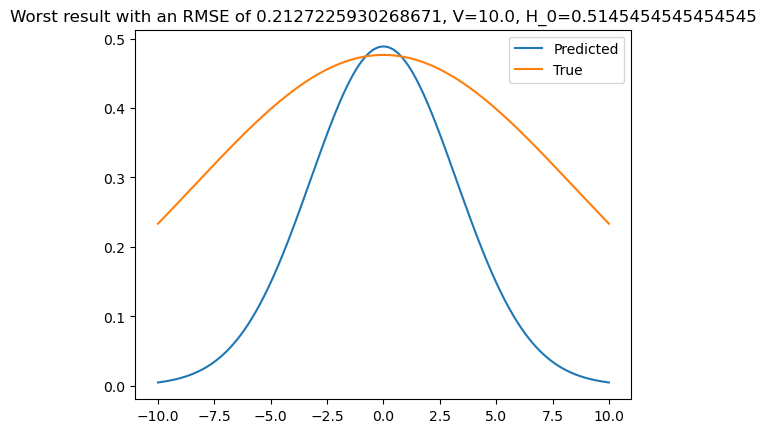

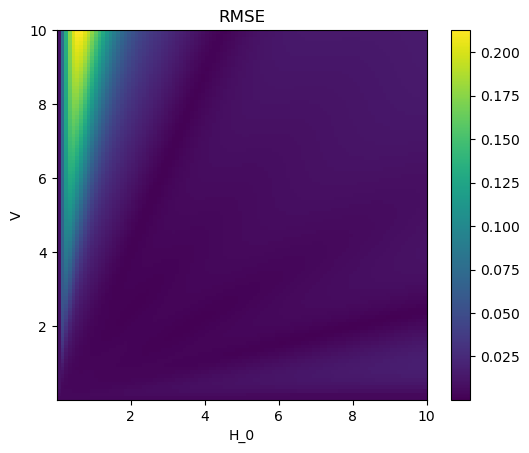

index 9900 was the worst result with an R^2 of -125509109.50168285 for V=10.0 and H_0=0.01


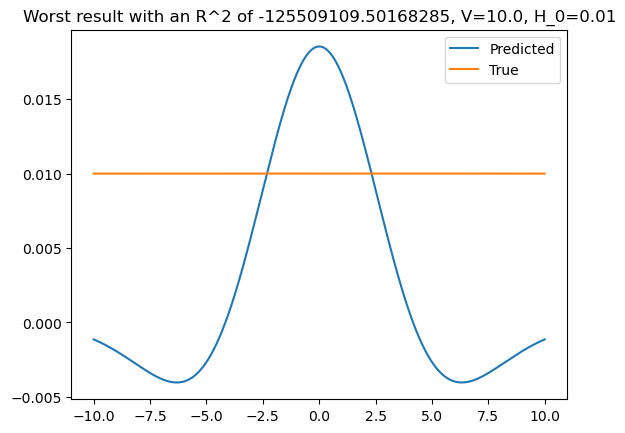

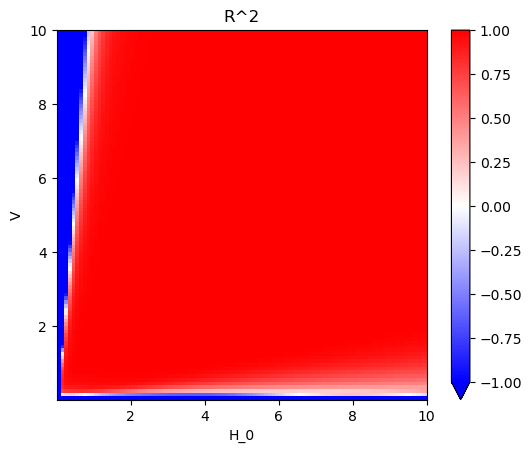

In [22]:
y_test_pred = reg.predict(x_test)

rmse, r2 = reg.test(x_test, y_test)

# RMSE
worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
print(f'index {worst_index_rmse} was the worst result with an RMSE of {rmse[worst_index_rmse]} for V={test_params[worst_index_rmse, 0]} and H_0={test_params[worst_index_rmse, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_rmse, :], label='Predicted')
plt.plot(x, y_test[worst_index_rmse, :], label='True')
plt.legend()
plt.title(f'Worst result with an RMSE of {rmse[worst_index_rmse]}, V={test_params[worst_index_rmse, 0]}, H_0={test_params[worst_index_rmse, 1]}')
plt.show()

rmse_arr = rmse.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
plt.imshow(rmse_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='viridis')
plt.colorbar()
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('RMSE')
plt.show()

# R2
worst_index_r2 = int(np.where(r2 == np.min(r2))[0])
print(f'index {worst_index_r2} was the worst result with an R^2 of {r2[worst_index_r2]} for V={test_params[worst_index_r2, 0]} and H_0={test_params[worst_index_r2, 1]}')

plt.figure()
plt.plot(x, y_test_pred[worst_index_r2, :], label='Predicted')
plt.plot(x, y_test[worst_index_r2, :], label='True')
plt.legend()
plt.title(f'Worst result with an R^2 of {r2[worst_index_r2]}, V={test_params[worst_index_r2, 0]}, H_0={test_params[worst_index_r2, 1]}')
plt.show()

r2_arr = r2.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plt.imshow(r2_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]], cmap='bwr', norm=divnorm)
plt.colorbar(extend='min')
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('R^2')
plt.show()